In [1]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Setup directories

In [2]:
root_dir = os.path.join("data", "traffic_sign_detection")
anno_dir = os.path.join(root_dir, "annotations")
img_dir  = os.path.join(root_dir, "images")


# PHASE 1: CLASSIFICATION

## 1. Load dataset and crop objects

In [3]:
img_lst = []
label_lst = []
for xml_file in os.listdir(anno_dir):
    xml_filepath = os.path.join(anno_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)

print(f"Number of objects: {len(img_lst)}")
print(f"Class names: {list(set(label_lst))}")


Number of objects: 1074
Class names: ['stop', 'crosswalk', 'speedlimit']


## 2. Preprocess & extract HoG features

In [4]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)
    resized_img = resize(
        img,
        output_shape=(32, 32),
        anti_aliasing=True
    )
    hog_feature = feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )
    return hog_feature

img_features_lst = []
for im in img_lst:
    img_features_lst.append(preprocess_img(im))
img_features = np.array(img_features_lst)
print(f"X shape: {img_features.shape}")


X shape: (1074, 324)


## 3. Encode labels & split

In [6]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)
random_state = 0
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)


## 4. Scale & train SVM

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
clf = SVC(kernel='rbf', random_state=random_state, probability=True, C=0.5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
score = accuracy_score(y_val, y_pred)
print(f"Evaluation results on val set: Accuracy {score:.4f}")


Evaluation results on val set: Accuracy 0.9721


# PHASE 2: LOCALIZATION

In [ ]:
def sliding_window(img, window_sizes, stride):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_height, window_width = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height
                windows.append([xmin, ymin, xmax, ymax])
    return windows


In [ ]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]
    current_img = img
    while True:
        acc_scale *= scale
        # use current_img.shape for h,w each level
        h = int(current_img.shape[0] * scale)
        w = int(current_img.shape[1] * scale)
        if h < min_size[0] or w < min_size[1]:
            break
        # cv2.resize expects (width, height)
        scaled = cv2.resize(current_img, (w, h))
        pyramid_imgs.append((scaled, acc_scale))
        current_img = scaled
    return pyramid_imgs


In [ ]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])
    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)
    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)
    return iou


In [ ]:
def nms(bboxes, iou_threshold=0.1):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]
    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)
    keep_bndbox = []
    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep_bndbox.append(i)
        other_indices = sorted_indices[1:]
        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.vstack([xmin[other_indices], ymin[other_indices], xmax[other_indices], ymax[other_indices]]).T,
            areas[i],
            areas[other_indices]
        )
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]
    return [bboxes[i] for i in keep_bndbox]


In [12]:
def visualize_bbox(img, bboxes, label_encoder, save_path=None):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0,0,0), 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    if save_path:
        # Convert back to BGR for saving
        save_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, save_img)



# Run detection on sample images

In [ ]:
img_filename_lst = os.listdir(img_dir)[:20]
conf_threshold = 0.95
stride = 12
window_sizes = [(32, 32), (64, 64), (128, 128)]


# Create output directory

In [ ]:
output_dir = os.path.join(root_dir, "output")
os.makedirs(output_dir, exist_ok=True)


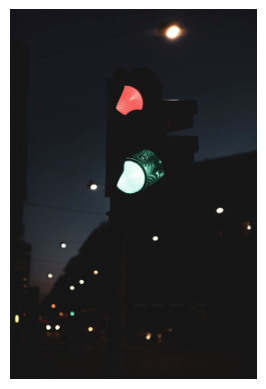

Saved visualization to data\traffic_sign_detection\output\road0.png


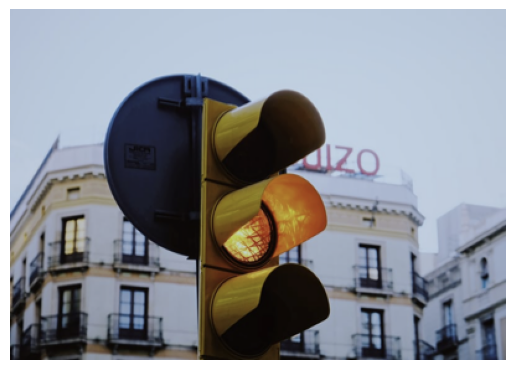

Saved visualization to data\traffic_sign_detection\output\road1.png


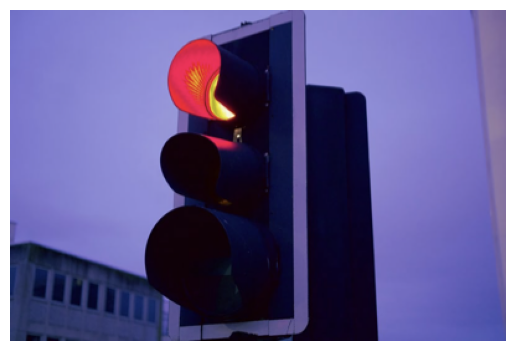

Saved visualization to data\traffic_sign_detection\output\road10.png


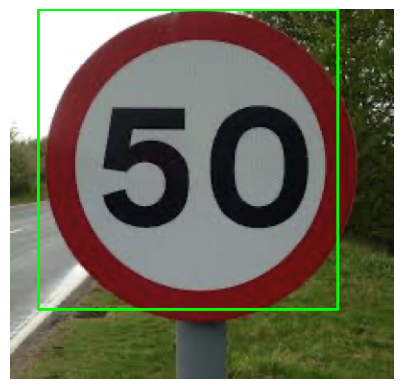

Saved visualization to data\traffic_sign_detection\output\road100.png


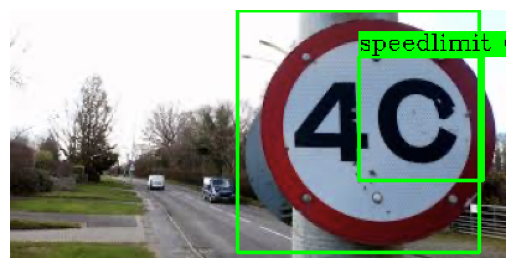

Saved visualization to data\traffic_sign_detection\output\road101.png


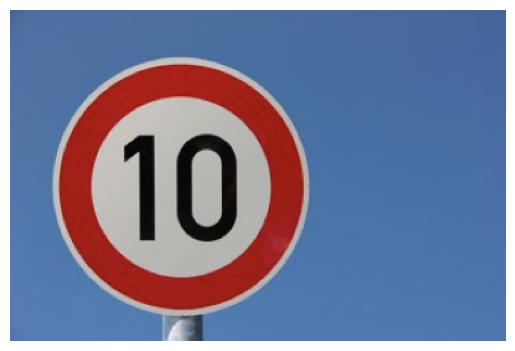

Saved visualization to data\traffic_sign_detection\output\road102.png


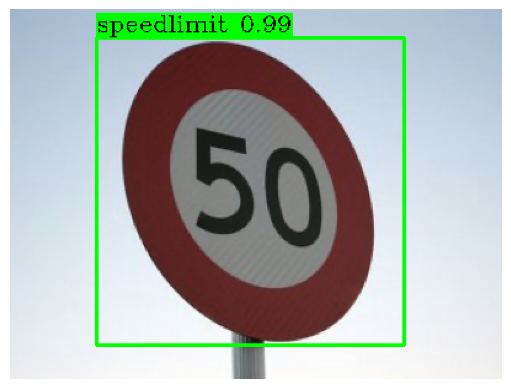

Saved visualization to data\traffic_sign_detection\output\road103.png


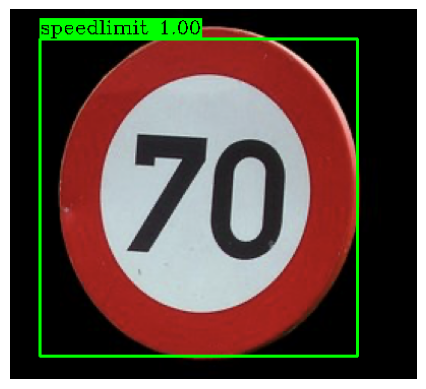

Saved visualization to data\traffic_sign_detection\output\road104.png


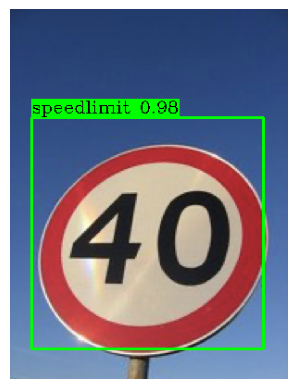

Saved visualization to data\traffic_sign_detection\output\road105.png


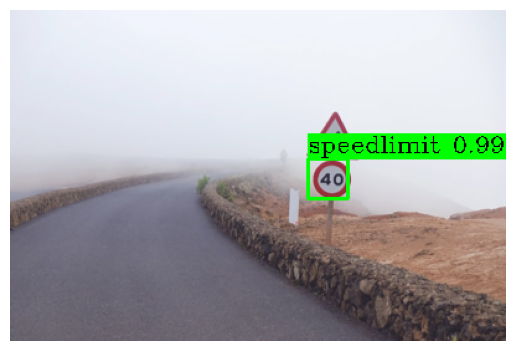

Saved visualization to data\traffic_sign_detection\output\road109.png


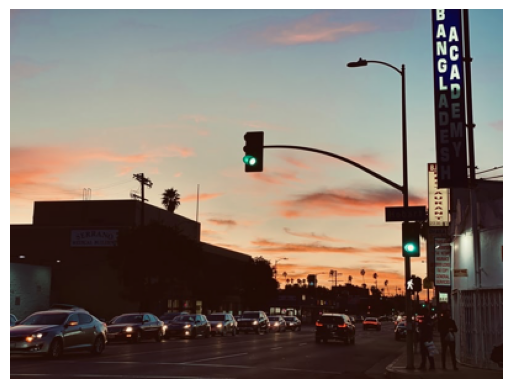

Saved visualization to data\traffic_sign_detection\output\road11.png


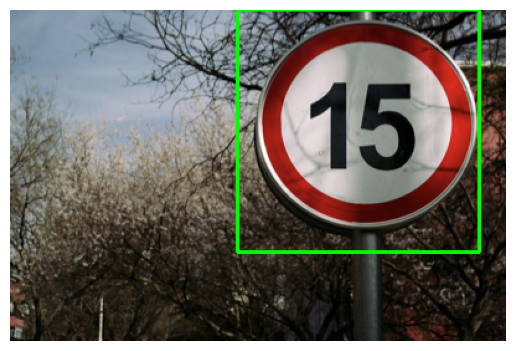

Saved visualization to data\traffic_sign_detection\output\road110.png


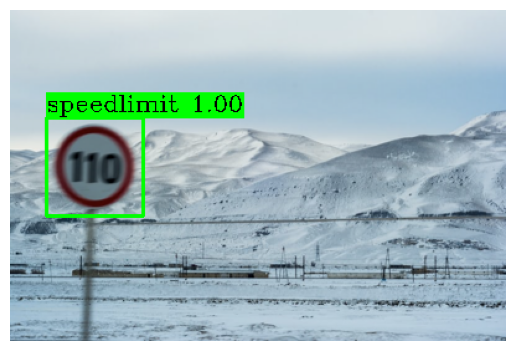

Saved visualization to data\traffic_sign_detection\output\road111.png


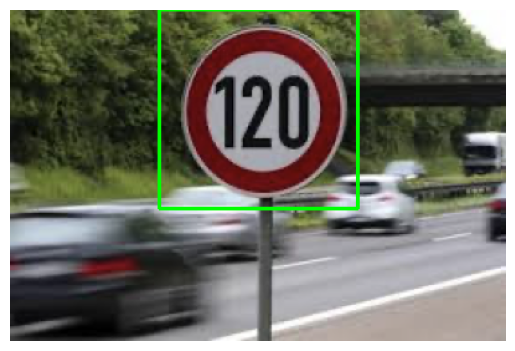

Saved visualization to data\traffic_sign_detection\output\road112.png


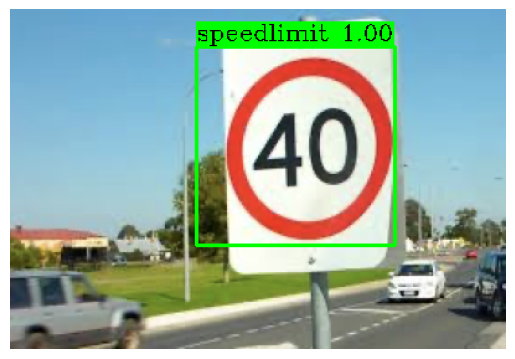

Saved visualization to data\traffic_sign_detection\output\road113.png


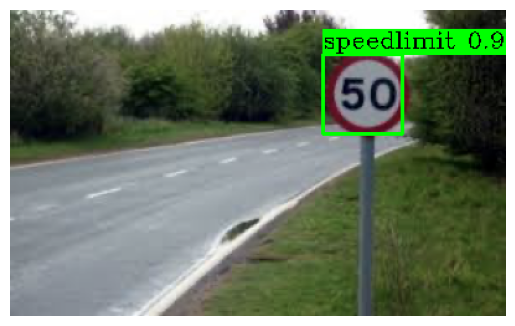

Saved visualization to data\traffic_sign_detection\output\road114.png


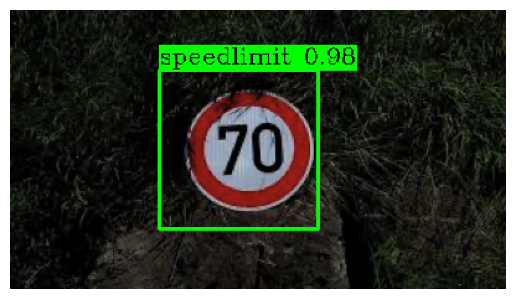

Saved visualization to data\traffic_sign_detection\output\road115.png


In [15]:
for img_filename in img_filename_lst:
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)
    bboxes = []
    pyramid_imgs = pyramid(img)

    for pyramid_img, scale_factor in pyramid_imgs:
        window_lst = sliding_window(pyramid_img, window_sizes, stride)
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            predict_id = np.argmax(decision)
            conf_score = decision[predict_id]
            xmin = int(xmin / scale_factor)
            ymin = int(ymin / scale_factor)
            xmax = int(xmax / scale_factor)
            ymax = int(ymax / scale_factor)
            bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])

    final_bboxes = nms(bboxes=bboxes, iou_threshold=0.5)
    # Visualize and save output
    img_vis = visualize_bbox(img.copy(), final_bboxes, label_encoder, save_path=os.path.join(output_dir, img_filename))
    print(f"Saved visualization to {os.path.join(output_dir, img_filename)}")
